In [35]:
# Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pickle
import nltk
from nltk.corpus import wordnet
from googletrans import Translator
import langid
from textblob import TextBlob
import spacy
import logging
import random


In [36]:
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\doubl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
logging.basicConfig(filename='chatbot.log', level=logging.INFO)

In [38]:
data_path = 'Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv'
data = pd.read_csv(data_path)

In [39]:
print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
print(data.info())


Dataset Overview:
   flags                                        instruction category  \
0      B   question about cancelling order {{Order Number}}    ORDER   
1    BQZ  i have a question about cancelling oorder {{Or...    ORDER   
2   BLQZ    i need help cancelling puchase {{Order Number}}    ORDER   
3     BL         I need to cancel purchase {{Order Number}}    ORDER   
4  BCELN  I cannot afford this order, cancel purchase {{...    ORDER   

         intent                                           response  
0  cancel_order  I've understood you have a question regarding ...  
1  cancel_order  I've been informed that you have a question ab...  
2  cancel_order  I can sense that you're seeking assistance wit...  
3  cancel_order  I understood that you need assistance with can...  
4  cancel_order  I'm sensitive to the fact that you're facing f...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 5 columns):
 #   Column 

In [16]:
data = data.dropna(subset=['instruction', 'intent', 'response'])
data['combined'] = data['instruction'] + " " + data['response']

In [41]:
X = data['instruction']
y = data['intent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [42]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [46]:

model = LogisticRegression()
model.fit(X_train_tfidf, y_train)


LogisticRegression()

In [47]:
predictions = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions))



Accuracy: 0.9773023255813954

Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.99      0.97      0.98       187
            change_order       0.92      0.98      0.95       187
 change_shipping_address       0.99      1.00      0.99       216
  check_cancellation_fee       1.00      1.00      1.00       199
           check_invoice       0.77      0.93      0.84       192
   check_payment_methods       1.00      0.99      1.00       206
     check_refund_policy       0.99      0.99      0.99       200
               complaint       1.00      1.00      1.00       203
contact_customer_service       1.00      0.99      0.99       208
     contact_human_agent       0.98      0.99      0.98       201
          create_account       1.00      0.97      0.98       217
          delete_account       0.96      0.99      0.98       178
        delivery_options       1.00      1.00      1.00       218
         delivery_per

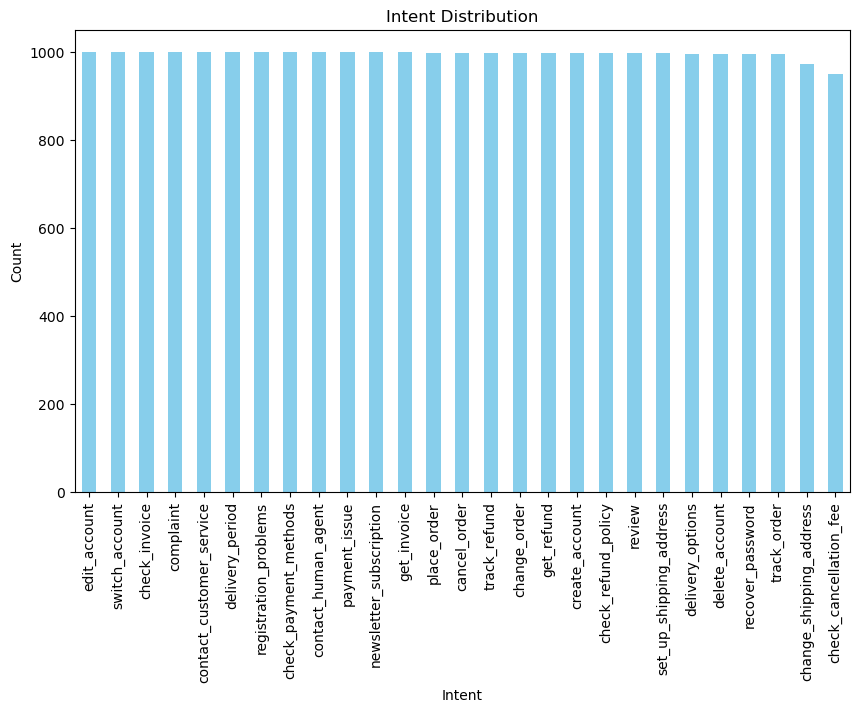

In [48]:
intent_counts = data['intent'].value_counts()
plt.figure(figsize=(10, 6))
intent_counts.plot(kind='bar', color='skyblue')
plt.title('Intent Distribution')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.show()

In [49]:
with open('vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)
with open('intent_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
print("\nModel and vectorizer saved successfully.")


Model and vectorizer saved successfully.


In [50]:
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word = random.choice(words)
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words = [synonym if w == word else w for w in new_words]
    return ' '.join(new_words)

In [51]:
def translate_text(text, target_language="en"):
    translator = Translator()
    translation = translator.translate(text, dest=target_language)
    return translation.text


In [52]:
def detect_language(text):
    return langid.classify(text)[0]

In [53]:
def extract_entities(text):
    doc = nlp(text)
    return {ent.text: ent.label_ for ent in doc.ents}

In [54]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity


In [55]:
def log_conversation(user_input, response):
    logging.info(f"User Input: {user_input}, Response: {response}")


In [60]:
def generate_response(user_input):
    user_input_tfidf = vectorizer.transform([user_input])
    intent = model.predict(user_input_tfidf)[0]
    confidence = model.predict_proba(user_input_tfidf).max()

    if confidence < 0.7:
        return "I'm sorry, I didn't understand that. Can you please rephrase?"
    else:
        return f"Detected intent: {intent}. How can I assist you further?"


In [61]:
def enhanced_chatbot(user_input, target_language="en"):
    detected_lang = detect_language(user_input)
    print(f"Detected language: {detected_lang}")

    if detected_lang != "en":
        user_input_en = translate_text(user_input, target_language="en")
    else:
        user_input_en = user_input

    entities = extract_entities(user_input_en)
    print(f"Extracted entities: {entities}")

    sentiment = analyze_sentiment(user_input_en)
    print(f"Sentiment: {'Positive' if sentiment > 0 else 'Negative' if sentiment < 0 else 'Neutral'}")

    response_en = generate_response(user_input_en)

    if target_language != "en":
        response = translate_text(response_en, target_language=target_language)
    else:
        response = response_en

    log_conversation(user_input, response)

    return response

In [62]:
examples = [
    ("¿Cómo cancelo mi pedido?", "es"),
    ("Quelle est la politique de remboursement ?", "fr"),
    ("How do I track my order?", "en")
]

for user_input, lang in examples:
    print(f"\nUser Input ({lang}): {user_input}")
    response = enhanced_chatbot(user_input, target_language=lang)
    print(f"Response: {response}")


User Input (es): ¿Cómo cancelo mi pedido?
Detected language: es
Extracted entities: {}
Sentiment: Neutral
Response: Intención detectada: cancel_order.¿Cómo puedo ayudarte más?

User Input (fr): Quelle est la politique de remboursement ?
Detected language: fr
Extracted entities: {}
Sentiment: Neutral
Response: Intention détectée: check_refund_policy.Comment puis-je vous aider davantage?

User Input (en): How do I track my order?
Detected language: en
Extracted entities: {}
Sentiment: Neutral
Response: Detected intent: track_order. How can I assist you further?
